# Prueba Tecnica

    Para poder realizar cada uno de los numerales deberas buscar una relacion entre las 2 tablas para consolidarlas en una sola. Posterior a esto podras empezar con la solucion de los puntos

    Nota:  
    - El punto A y B los debes solucionar tanto en Sql como python. El punto C lo podras realizar con el lenguaje de tu preferencia
    - para obtener las bases de datos solo deberas ejecutar el bloque de codigo llamado 'DATA' en caso de un error puedes pedir ayuda

In [1]:
import pandas as pd
import numpy as np
from os import path
import pandasql as ps
import seaborn as sns
import matplotlib.pyplot as plt
import empiricaldist
import janitor
import scipy.stats
import seaborn as sns
import sklearn.metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as ss
import session_info

# Data

In [2]:

'''
    Barrios: Información de los barrios (nombre y código)
    clientes: Información transaccional del cliente 
    
'''

df_barrios = pd.read_csv(path.join('Bases_insumo','barrios.csv'))
df_clientes = pd.read_csv(path.join('Bases_insumo','clientes.csv'))
df_dispositivos = pd.read_csv(path.join('Bases_insumo','dispositivos.csv'))
df_dispositivos.rename({'codigo':'cod_dispositivo'}, axis = 1, inplace= True)

df_join = df_barrios.merge(df_dispositivos, left_on ='codigo', 
                          right_on = 'id_barrio', how = 'inner').merge(df_clientes, on = 'cod_dispositivo', how = 'inner')


In [3]:
df_join.head()

,codigo,nombre,tipo,cod_dispositivo,latitud,longitud,id_barrio,num_doc,tipo_doc,canal,num_trx,mnt_total_trx
0,737998257,La Campina,POS,12202503,3.479572,-76.525582,737998257,-2393994463924208659,1,POS,2,12202503.0
1,737998257,La Campina,POS,10521045,3.480517,-76.525275,737998257,-5675531380015678594,1,POS,1,5260522.5
2,737998257,La Campina,POS,10521045,3.480517,-76.525275,737998257,-5066077049535851626,1,POS,1,5260522.5
3,737998257,La Campina,POS,13238282,3.479491,-76.525818,737998257,-5791329717693361241,1,POS,1,6619141.0
4,737998257,La Campina,POS,12567517,3.480958,-76.525153,737998257,-397966594878551344,1,POS,1,6283758.5


# Punto a

* Generar el listado de clientes con transacciones en 5 o más barrios.

In [3]:
#Solución en sql

query = '''
    SELECT DISTINCT num_doc, sum(num_trx) as cant_transacciones, count(DISTINCT(id_barrio)) as cant_barrios
    FROM df_join
    GROUP BY num_doc
    HAVING cant_barrios > 5
    ORDER BY cant_barrios DESC;
'''

In [4]:
ps.sqldf(query, locals())

,num_doc,cant_transacciones,cant_barrios
0,-6943732889918790302,546,83
1,-6318594648243260200,307,77
2,3949050160426632961,393,75
3,956540030589798895,311,74
4,3785376175516210347,372,63
...,...,...,...
2995,-8970554719011755860,59,6
2996,-9016704368719499354,8,6
2997,-9044712566978972844,75,6
2998,-9099385232054024088,27,6


In [5]:
query_nombre_barrios = '''
    SELECT DISTINCT nombre
    FROM df_join
'''

In [6]:
conteo = df_join.groupby('num_doc')['nombre'].nunique()
conteo

docs_usuarios_5barrios = pd.DataFrame(conteo[conteo > 5])

docs_usuarios_5barrios.head()

,nombre
num_doc,
-9218698523982046880,8
-9210147727599394517,7
-9202442483227019464,6
-9202223027335988936,7
-9186693395875698210,18


In [ ]:
#Mejorando Query en Pandas - post-Prueba presencial

#df_join.groupby(['num_doc', 'nombre'])['num_trx'].count().to_frame()

#df_join.groupby(['num_doc', 'nombre'])['num_trx'].aggregate(['count', 'sum'])

In [ ]:
df_join.columns

In [ ]:
#Solución en pandas



# Punto b

* ¿Cuáles son los 6 barrios donde la mayor cantidad de clientes únicos realizan transacciones en
dispositivos tipo PAC? La respuesta debe incluir la cantidad de clientes únicos asociados a estos
barrios.


In [7]:
query_3 = '''
    SELECT nombre, count(distinct(num_doc)) as clientes_unicos
    FROM df_join
    GROUP BY nombre
    ORDER BY clientes_unicos DESC
    LIMIT 6;
'''

In [8]:
ps.sqldf(query_3, locals())

,nombre,clientes_unicos
0,San Pedro,2516
1,San Vicente,1888
2,Urbanización San Juaquín,1756
3,Santa Mónica Residencial,1561
4,Chipichape,1555
5,Unidad Residencial Santiago de Cali,1547


In [9]:
cant_clientes_barrios = df_join.groupby('nombre')['num_doc'].nunique()
df_cant_clientes_barrios = pd.DataFrame(cant_clientes_barrios)
cond = df_cant_clientes_barrios.loc[:,'num_doc'] > 5
df_cant_clientes_barrios.loc[cond, :].sort_values(by = 'num_doc', ascending = False)

,num_doc
nombre,
San Pedro,2516
San Vicente,1888
Urbanización San Juaquín,1756
Santa Mónica Residencial,1561
Chipichape,1555
...,...
El Dorado,6
Unidad Residencial Bueno Madrid,6
Alto de los Chorros,6


# Punto c

Realizar analisis exploratorio de los datos y conclusiones. 

NOTA: Se debe agregar la documentación y trazabilidad del proceso realizado (Codigos y gráficas con las que se hicieron los análisis)

# **Análisis Exploratorio - Transacciones en los barrios de Medellín**

**Nota inicial**: Hipótesis sobre variables cuya información es limitada con el fin de enriquecer el análisis

Conociendo el conjunto de datos:

In [72]:
df_join.head()

,codigo,nombre,tipo,cod_dispositivo,latitud,longitud,id_barrio,num_doc,tipo_doc,canal,num_trx,mnt_total_trx,ubicacion
0,737998257,La Campina,POS,12202503,3.479572,-76.525582,737998257,-2393994463924208659,1,POS,2,12202503.0,"(3.479572082, -76.52558242)"
1,737998257,La Campina,POS,10521045,3.480517,-76.525275,737998257,-5675531380015678594,1,POS,1,5260522.5,"(3.480516553, -76.52527472)"
2,737998257,La Campina,POS,10521045,3.480517,-76.525275,737998257,-5066077049535851626,1,POS,1,5260522.5,"(3.480516553, -76.52527472)"
3,737998257,La Campina,POS,13238282,3.479491,-76.525818,737998257,-5791329717693361241,1,POS,1,6619141.0,"(3.47949063002, -76.5258184734)"
4,737998257,La Campina,POS,12567517,3.480958,-76.525153,737998257,-397966594878551344,1,POS,1,6283758.5,"(3.480957671, -76.52515269)"


In [10]:
df_join.dtypes

codigo               int64
nombre              object
tipo                object
cod_dispositivo      int64
latitud            float64
longitud           float64
id_barrio            int64
num_doc              int64
tipo_doc             int64
canal               object
num_trx              int64
mnt_total_trx      float64
dtype: object

A simple vista podemos observar que el conjunto de datos contiene el registro de transacciones realizadas en diferentes puntos de servicio de distintos barrios y los montos de las mismas.

En aras de un análisis más completo que nos permita comprender mejor el conjunto de datos surgen varios interrogantes:

*¿A qué ciudad pertenecen los barrios que aparecen en el conjunto de datos? ¿cuál es su nivel socioeconómico?*

La primera parte del análisis estará centrada en levantar la información faltante, limpiar y preparar los datos para el análisis.

**1. Conociendo la ciudad de los datos.**

Para este punto, partiremos de las coordenadas que contiene el dataset.

In [ ]:
pip install reverse_geocoder

In [11]:
import reverse_geocoder as rg

In [12]:
coordinate = (3.403659, -76.530091)
rg.search(coordinate) #La función rg.search devuelve un diccionario con la información de las coordenadas proporcionadas 

Loading formatted geocoded file...


[{'lat': '3.43722',
  'lon': '-76.5225',
  'name': 'Cali',
  'admin1': 'Valle del Cauca',
  'admin2': '',
  'cc': 'CO'}]

Dado que la función se aplica a Tuplas, es necesario crear una columna en el dataframe con una tupla que contenga la latitud y la longitud:

In [13]:
def obtener_ubicacion(latitud, longitud): 
    return (latitud, longitud)

In [14]:
df_join['ubicacion'] = df_join.apply(lambda df: obtener_ubicacion(df['latitud'], df['longitud']), axis = 1)

Teniendo en cuenta que la función *rg.search()* devuelve una lista que contiene un diccionario con diferentes datos de acuerdo a la ubicación, es necesario crear una función que retorne únicamente el valor de la clave *'name'* para posteriormente aplicarla a los datos.

In [15]:
def obtener_ciudad(ubicacion):
    return rg.search(ubicacion)[0]['name']

In [ ]:
#df_join['ciudad'] = df_join.apply(lambda df: obtener_ciudad(df['ubicacion']), axis = 1)

 Aplicarlo al dataframe principal tiene un costo de memoria muy alto, por lo cual es necesario realizar unos pasos adicionales:

**-** Definimos un subdataframe con la información de los barrios y su ubicación

In [16]:
df_barrios_ubic = (
    df_join[['nombre', 'ubicacion']] #Subdataframe con el nombre y la ubicación del barrio
    .groupby('nombre', as_index = False) #Agrupo por nombre de barrio 
    .first() #Tomo solo la primera ubicación (todas arrojarían la misma ciudad)
)

Ahora el costo de memoria de aplicar la función *obtener_ciudad* es menor:

In [17]:
df_barrios_ubic['ciudad'] = (df_barrios_ubic
                             .apply(
                                 lambda df: obtener_ciudad(df['ubicacion']), #Aplico la función al Dataframe
                                 axis = 1  #Indico que debe iterar a través de la columna
                             )
)

df_barrios_ubic.head()

,nombre,ubicacion,ciudad
0,12 de Octubre,"(3.427925, -76.501541)",Cali
1,20 de Julio,"(3.43627671667, -76.5128989173)",Cali
2,3 de Julio,"(3.430406808, -76.5390441)",Cali
3,Acueducto San Antonio,"(3.446740019, -76.54089095)",Cali
4,Aguablanca,"(3.431530347, -76.51957472)",Cali


In [18]:
(
    df_barrios_ubic
    .ciudad
    .value_counts()
)

Cali       276
Jamundi      1
Name: ciudad, dtype: int64

In [102]:
df_barrios_ubic.query('ciudad == "Jamundi"')

,nombre,ubicacion,ciudad
187,Parcelaciones Pance,"(3.34869394999, -76.5305870537)",Jamundi


Al verificar en la web, las Parcelaciones de Pance están ubicadas en la ciudad de Cali, por lo que procedemos a corregir el dato y a confirmar que todo el conjunto de datos está centrado en la actividad de los puntos de servicio de la ciudad de Cali, información importante para el análisis.

In [19]:
cond = df_barrios_ubic.loc[:,'ciudad'] == 'Jamundi'

In [20]:
df_barrios_ubic.loc[cond, 'ciudad'] = 'Cali'

In [21]:
(
    df_barrios_ubic
    .ciudad
    .value_counts()
)

Cali    277
Name: ciudad, dtype: int64

Teniendo en cuenta que solo tenemos datos de una ciudad y, en aras de optimizar el gasto de memoria, para este ejercicio sería inoficioso hacer el merge de la ciudad con el conjunto de datos principal, por lo que omitiremos este paso.

**2. Conociendo la segmentación socioeconómica del conjunto de datos** 

Teniendo en cuenta que conocemos el barrio y la ciudad presentes en el conjunto de datos, puede ser de suma importancia conocer la segmentación socio-económica.

Para ello, utilizaré datos sobre *Estratificación socioeconómica según estrato, en Cali* descargados del portal [datos.gov.co](https://www.datos.gov.co/widgets/pfix-sugc)

In [22]:
estratificacion_cali = pd.read_csv('estratificacion_cali.csv')
estratificacion_cali.head()

,Código único,Barrio,Lados de manzana por estrato 1,Lados de manzana por estrato 2,Lados de manzana por estrato 3,Lados de manzana por estrato 4,Lados de manzana por estrato 5,Lados de manzana por estrato 6,Sin vivienda,Estrato moda
0,101,Terrón Colorado,84,309,-,-,-,2,43,2
1,102,Vista Hermosa,199,18,-,-,-,-,30,1
2,196,Patio Bonito,161,-,-,-,-,-,37,1
3,199,Aguacatal,209,23,4,5,1,4,59,1
4,201,Santa Rita,-,-,-,2,6,30,3,6


Teniendo en cuenta que hay diferentes estratos sociales en un barrio de acuerdo a los sectores del mismo, utilizaremos como definitivo el *Estrato moda*, es decir, el valor que más se repite.

In [23]:
estratificacion_cali.columns

Index(['Código único', 'Barrio', 'Lados de manzana por estrato 1',
       'Lados de manzana por estrato 2', 'Lados de manzana por estrato 3',
       'Lados de manzana por estrato 4', 'Lados de manzana por estrato 5',
       'Lados de manzana por estrato 6', 'Sin vivienda', 'Estrato moda'],
      dtype='object')

In [24]:
#Depuramos datos innecesarios

estratificacion_cali = estratificacion_cali[['Barrio', 'Estrato moda']]

In [25]:
#Renombramos las columnas

estratificacion_cali.columns = ['nombre', 'estrato']

In [26]:
estratificacion_cali.head()

,nombre,estrato
0,Terrón Colorado,2
1,Vista Hermosa,1
2,Patio Bonito,1
3,Aguacatal,1
4,Santa Rita,6


Realizamos el merge con el conjunto de datos principales:

In [27]:
df_join_merged = pd.merge(df_join, estratificacion_cali, on = 'nombre', how = 'left')
df_join_merged.head()

,codigo,nombre,tipo,cod_dispositivo,latitud,longitud,id_barrio,num_doc,tipo_doc,canal,num_trx,mnt_total_trx,ubicacion,estrato
0,737998257,La Campina,POS,12202503,3.479572,-76.525582,737998257,-2393994463924208659,1,POS,2,12202503.0,"(3.479572082, -76.52558242)",NaN
1,737998257,La Campina,POS,10521045,3.480517,-76.525275,737998257,-5675531380015678594,1,POS,1,5260522.5,"(3.480516553, -76.52527472)",NaN
2,737998257,La Campina,POS,10521045,3.480517,-76.525275,737998257,-5066077049535851626,1,POS,1,5260522.5,"(3.480516553, -76.52527472)",NaN
3,737998257,La Campina,POS,13238282,3.479491,-76.525818,737998257,-5791329717693361241,1,POS,1,6619141.0,"(3.47949063002, -76.5258184734)",NaN
4,737998257,La Campina,POS,12567517,3.480958,-76.525153,737998257,-397966594878551344,1,POS,1,6283758.5,"(3.480957671, -76.52515269)",NaN


In [115]:
df_join_merged.sample(10)

,codigo,nombre,tipo,cod_dispositivo,latitud,longitud,id_barrio,num_doc,tipo_doc,canal,num_trx,mnt_total_trx,ubicacion,estrato
42790,738000407,Urbanización San Juaquín,POS,11303609,3.366801,-76.527968,738000407,-7539593019751320700,1,POS,1,5651804.5,"(3.36680096973, -76.5279684014)",NaN
81485,737998832,San Pedro,DISPENSADOR,600,3.450122,-76.532928,737998832,2903462039265902287,1,DISPENSADOR,1,300.0,"(3.45012219, -76.5329282)",3
68465,737998194,Santa Mónica Residencial,MF,5210,3.472052,-76.528015,737998194,-7934596012811782026,2,MF,1,2605.0,"(3.472052, -76.528015)",NaN
70638,738000386,La Ciudadela Confandi,CB,1013416598,3.388080,-76.520140,738000386,-6168238322585651735,1,CB,1,506708299.0,"(3.38808, -76.52014)",NaN
36561,737998912,El Calvario,DISPENSADOR,8031,3.449273,-76.528759,737998912,3300000114550460672,1,DISPENSADOR,2,8031.0,"(3.44927335, -76.5287594)",3
84413,737998832,San Pedro,POS,11126562,3.452429,-76.530228,737998832,-2269830880618748380,1,POS,1,5563281.0,"(3.452429136, -76.53022839)",3
39341,737998825,Ciudadela Floralia,POS,11127065,3.494212,-76.494971,737998825,9085985241497872702,1,POS,5,27817662.5,"(3.494211515, -76.49497145)",2
81544,737998832,San Pedro,DISPENSADOR,600,3.450122,-76.532928,737998832,8798468695133417824,1,DISPENSADOR,1,300.0,"(3.45012219, -76.5329282)",3
55511,737998851,Ciudad Capri,DISPENSADOR,8064,3.392730,-76.544289,737998851,-3139123907487479639,1,DISPENSADOR,3,12096.0,"(3.39272972, -76.54428937)",5
22441,737999427,Urbanización Tequendama,SAI,77,3.421885,-76.547348,737999427,5518408100027431367,1,SAI,1,38.5,"(3.42188529, -76.54734841)",5


Analizando valores nulos.

In [28]:
(
    df_join_merged
    .isnull()
    .any()
)

codigo             False
nombre             False
tipo               False
cod_dispositivo    False
latitud            False
longitud           False
id_barrio          False
num_doc            False
tipo_doc           False
canal              False
num_trx            False
mnt_total_trx      False
ubicacion          False
estrato             True
dtype: bool

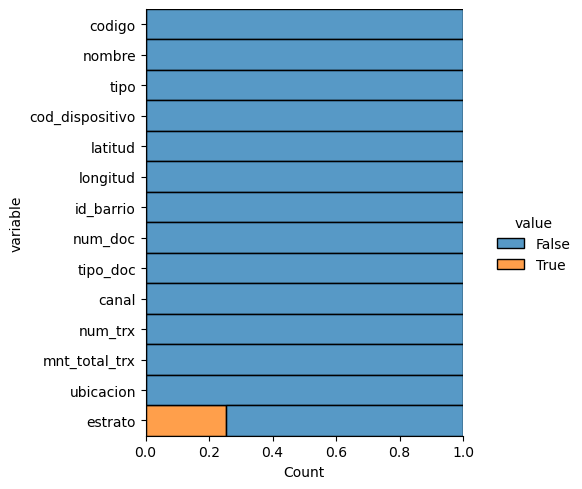

In [29]:
#Proporción de los valores nulos

(
    df_join_merged
    .isnull()
    .melt()
    .pipe(
        lambda df: sns.displot(
            data = df,
            y = 'variable',
            hue = 'value',
            multiple = 'fill'
        )
    )
)

In [31]:
(
    df_join_merged
    .isnull()
    .sum()
)

codigo                 0
nombre                 0
tipo                   0
cod_dispositivo        0
latitud                0
longitud               0
id_barrio              0
num_doc                0
tipo_doc               0
canal                  0
num_trx                0
mnt_total_trx          0
ubicacion              0
estrato            23832
dtype: int64

In [32]:
23832 / df_join_merged.shape[0]

0.2518972624458303

Teniendo en cuenta que los valores representan un 25.19% de los datos, es necesario encontrar los valores faltantes, pues eliminarlos sería perder gran parte de la muestra.

In [33]:
mask = df_join_merged.loc[:,'estrato'].isnull()

In [34]:
df_join_merged.loc[mask, 'nombre'].unique()

array(['La Campina', 'El Trebol', 'Jorge Eliecer Gaitan',
       'Altos de Santa Isabel La Morelia', 'Rafael Uribe',
       'Alfonso Barberena', 'Paseo de los Almendros', 'Los Parques',
       'Departamental', 'Olaya Herrera', 'Bretana', 'Atanasio Girardota',
       'Unidad Residencial Santiago de Cali', 'La Rivera',
       'Alirio Mora Beltrán', 'Manuel María Buenventura',
       'U Dep Galindo Plaza Toros', 'León XII', 'Lleras Restrepo II',
       'Santa Bárbara', 'Los Portales-Nuevo Rey', 'Los Alcázares',
       'Canaveralejo-Seguros Patria', 'Quintas de Don Simón',
       'Guillermo León Valencia', 'Los Andes B-La Riviera',
       'San Francisco-Berlín', 'Juanambu', 'Parque de la Caña',
       '12 de Octubre', 'Siloe', 'Petecuy II', 'Canaverales Los Samanes',
       'San Luis II', 'Cuarto de Legua-Guadalupe', 'Los Comuneros I',
       'Ciudad Los Á\x81lamos', 'San Luis', 'Camino Real-Joaquín Borrero',
       'Acueducto San Antonio', 'El Á\x81ngel del Hogar',
       'U Dep Panameric

Una hipótesis acerca de la cantidad de valores nulos es que muchos de estos no entran en el merge por asuntos de tildes, mayúsculas, ñ's o, incluso, guiones, por lo que procederé a repetir el ejercicio estandarizando primero los nombres en ambas tablas.

In [42]:
def quitar_tildes(palabra):
    '''
    La función toma una palabra y la devuelve sin tildes y en formato título
    '''
    palabra = palabra.lower()
    vocales = [['á', 'a'], ['é', 'e'], ['í', 'i'], ['ó', 'o'], ['ú', 'u'], ['-', ' '], ['ñ', 'n']]
    for i,j in vocales:
        palabra = palabra.replace(i, j)
    return palabra.title()

In [43]:
df_join['nombre'] = df_join['nombre'].apply(quitar_tildes)
df_join.sample(10)

,codigo,nombre,tipo,cod_dispositivo,latitud,longitud,id_barrio,num_doc,tipo_doc,canal,num_trx,mnt_total_trx,ubicacion
75509,737998252,Chipichape,DISPENSADOR,5773,3.477415,-76.526735,737998252,-2354803928946951333,1,DISPENSADOR,3,8659.5,"(3.47741469, -76.5267353)"
3740,737999419,El Sena,DISPENSADOR,6519,3.465296,-76.502172,737999419,7893527032739616341,1,DISPENSADOR,4,13038.0,"(3.4652962, -76.50217218)"
35739,738000401,Belalcazar,POS,13882287,3.443513,-76.521718,738000401,-1727955816418363653,1,POS,1,6941143.5,"(3.443512858, -76.52171826)"
16042,737998941,La Hacienda,POS,14474746,3.392659,-76.532574,737998941,-8287737188830239265,1,POS,4,28949492.0,"(3.39265933, -76.53257446)"
41158,738000407,Urbanizacion San Juaquin,DISPENSADOR,4783,3.369079,-76.527774,738000407,-2865679335813302558,1,DISPENSADOR,1,2391.5,"(3.369079, -76.527774)"
20358,737996829,El Refugio,DISPENSADOR,2110,3.400229,-76.546695,737996829,1572717900281059123,1,DISPENSADOR,1,1055.0,"(3.40022945, -76.54669505)"
91366,738000400,Lili,SAI,265,3.369544,-76.523664,738000400,-1515788924913100371,1,SAI,1,132.5,"(3.36954367, -76.52366403)"
74667,737998252,Chipichape,DISPENSADOR,1117,3.477404,-76.526705,737998252,1254715916995759771,1,DISPENSADOR,2,1117.0,"(3.47740375, -76.52670515)"
50398,737998120,Champagnat,POS,12783122,3.434203,-76.534886,737998120,-3311322937175334971,1,POS,1,6391561.0,"(3.434203472, -76.53488628)"
32240,737998287,La Merced,DISPENSADOR,2485,3.447709,-76.536663,737998287,-663521977386666191,1,DISPENSADOR,2,2485.0,"(3.44770855, -76.53666332)"


In [44]:
estratificacion_cali['nombre'] = estratificacion_cali['nombre'].apply(quitar_tildes)

In [45]:
estratificacion_cali.sample(10)

,nombre,estrato
309,Siloe,1
33,Los Libertadores,3
293,Nueva Tequendama,5
353,Comuna 8,3
143,Barrio Departamental,4
312,Brisas De Mayo,1
228,Antonio Narino,2
224,El Morichal,2
16,La Campina,4
150,San Judas Tadeo Ii,3


In [46]:
df_join_merged_v2 = pd.merge(df_join, estratificacion_cali, on = 'nombre', how = 'left')

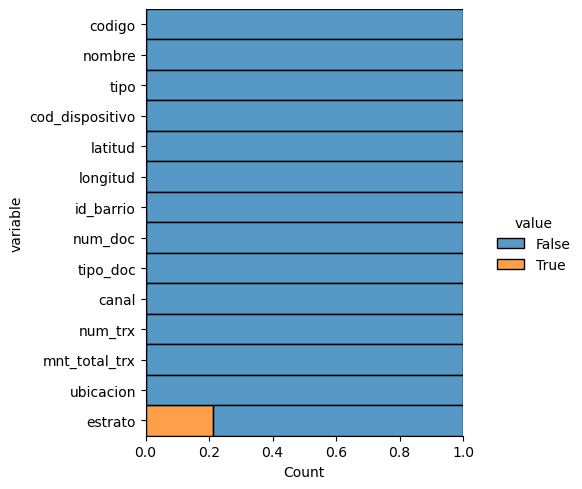

In [47]:
(
    df_join_merged_v2
    .isnull()
    .melt()
    .pipe(
        lambda df: sns.displot(
            data = df,
            y = 'variable',
            hue = 'value',
            multiple = 'fill'
        )
    )
)

In [48]:
(
    df_join_merged_v2
    .isnull()
    .sum()
)

codigo                 0
nombre                 0
tipo                   0
cod_dispositivo        0
latitud                0
longitud               0
id_barrio              0
num_doc                0
tipo_doc               0
canal                  0
num_trx                0
mnt_total_trx          0
ubicacion              0
estrato            20107
dtype: int64

Al pasar los subdataframes por la función de estandarización de los nombres, se encontraron 3.700 datos (aprox.). Es necesario seguir limpiando hasta encontrar casi la totalidad de estos.

In [49]:
mask_2 = df_join_merged_v2.loc[:,'estrato'].isnull()

In [61]:
barrios_faltantes = list(df_join_merged_v2.loc[mask_2, :]['nombre'].unique())

In [63]:
barrios_faltantes.sort()

In [77]:
barrios_faltantes

['12 De Octubre',
 'Acueducto San Antonio',
 'Alfonso Barberena',
 'Alfonso Lopez I',
 'Alfonso Lopez Ii',
 'Alfonso Lopez Iii',
 'Alto De Los Chorros',
 'Alto Jordan',
 'Altos De Santa Isabel La Morelia',
 'Atanasio Girardota',
 'A\x81Rea Libre Parque Del Amor',
 'Bajos Ciudad Cordoba',
 'Boyaca',
 'Brisas De Los A\x81Lamos',
 'Caldas',
 'Camino Real Joaquin Borrero',
 'Camino Real Los Fundadores',
 'Canaveralejo Seguros Patria',
 'Canaverales Los Samanes',
 'Cataya El Gran Limonar',
 'Ciudad Los A\x81Lamos',
 'Ciudad Talanga',
 'Ciudadela Del Rio',
 'Ciudadela Paso Ancho',
 'Cuarto De Legua Guadalupe',
 'Departamental',
 'El A\x81Ngel Del Hogar',
 'Esmeralda',
 'Guillermo Leon Valencia',
 'Jose M. Cordoba',
 'Jose Manuel Marroquin I',
 'Jose Manuel Marroquin Ii',
 'La Ciudadela Confandi',
 'La Rivera',
 'Leon Xii',
 'Lleras Restrepo Ii',
 'Los Andes B La Riviera',
 'Los Comuneros I',
 'Los Comuneros Ii',
 'Los Parques',
 'Los Portales Nuevo Rey',
 'Los Rubles',
 'Manuel Maria Buenven

Los datos faltantes se pueden deber a diferencias en la sintaxis entre los nombres de los barrios en el conjunto de datos principal y los nombres en el conjunto de datos de la estratificación descargados del portal gubernamental del Valle del Cauca. Por tal motivo, se procede a verificar y estandarizar de forma manual.

In [64]:
cond_parq_am = df_join.loc[:,'nombre'] == 'A\x81Rea Libre Parque Del Amor'

In [68]:
df_join.loc[cond_parq_am, 'nombre'] = 'Area en desarrollo Parque del Amor'

In [69]:
cond_ciud_cord = df_join.loc[:,'nombre'] == 'Bajos Ciudad Cordoba'

In [70]:
df_join.loc[cond_ciud_cord, 'nombre'] = 'Ciudad Cordoba'

In [71]:
cond_bris_al = df_join.loc[:,'nombre'] == 'Brisas De Los A\x81Lamos'

In [72]:
df_join.loc[cond_bris_al, 'nombre'] = 'Brisas de Los Alamos'

In [73]:
cond_ciud_al = df_join.loc[:,'nombre'] == 'Ciudad Los A\x81Lamos'

In [74]:
df_join.loc[cond_ciud_al, 'nombre'] = 'Ciudad Los Alamos'

In [75]:
cond_ang_hog = df_join.loc[:,'nombre'] == 'El A\x81Ngel Del Hogar'

In [76]:
df_join.loc[cond_ang_hog, 'nombre'] = 'El Angel del Hogar'

In [78]:
cond_valle_g = df_join.loc[:,'nombre'] == 'Ville Grande'

In [79]:
df_join.loc[cond_valle_g, 'nombre'] = 'Valle Grande'

In [95]:
est_cali_clean = pd.read_csv('estratificacion_cali_clean.csv')
est_cali_clean = est_cali_clean[['Barrio', 'Estrato moda']]
est_cali_clean.columns = ['nombre', 'estrato']
est_cali_clean.head()

,nombre,estrato
0,12 De Octubre,3
1,20 de Julio,3
2,3 de Julio,4
3,Aguablanca,3
4,Aguacatal,1


In [96]:
df_join['nombre'] = df_join['nombre'].apply(quitar_tildes)
est_cali_clean['nombre'] = est_cali_clean['nombre'].apply(quitar_tildes)

In [97]:
df_join_merged_v3 = pd.merge(df_join, est_cali_clean, on = 'nombre', how = 'left')

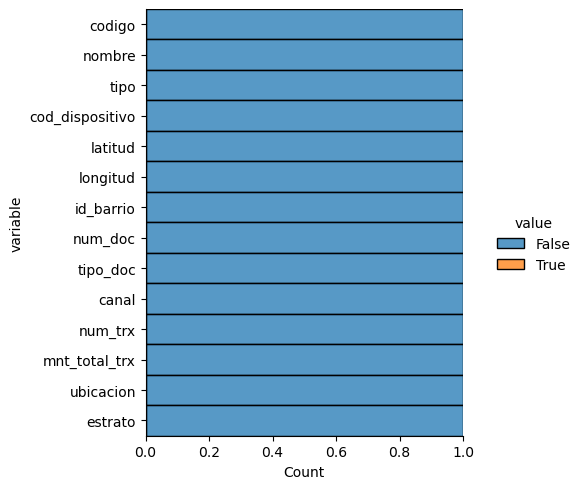

In [98]:
(
    df_join_merged_v3
    .isnull()
    .melt()
    .pipe(
        lambda df: sns.displot(
            data = df,
            y = 'variable',
            hue = 'value',
            multiple = 'fill'
        )
    )
)

In [99]:
(
    df_join_merged_v3
    .isnull()
    .sum()
)

codigo              0
nombre              0
tipo                0
cod_dispositivo     0
latitud             0
longitud            0
id_barrio           0
num_doc             0
tipo_doc            0
canal               0
num_trx             0
mnt_total_trx       0
ubicacion           0
estrato            11
dtype: int64

In [100]:
mask_4 = df_join_merged_v3.loc[:,'estrato'].isnull()

df_join_merged_v3.loc[mask_4, 'nombre'].unique()

array(['U Dep Panamericana Ant Hipodromo', 'Alto De Los Chorros'],
      dtype=object)

In [14]:
df_join.describe(include = object)

,nombre,tipo,canal
count,94610,94610,94610
unique,277,6,6
top,San Pedro,DISPENSADOR,DISPENSADOR
freq,5304,37690,37654


Tal como podemos observar, en el conjunto de datos contamos con tres variables categóricas, *nombre* que contiene el nombre del barrio donde se cuenta con un punto de transacciones, *tipo y canal* que contienen el tipo de transacción que se realiza y el dispositivo mediente el cual se lleva a cabo. No obstante, estas dos últimas pareciera que contienen la misma información y, de ser así, podríamos prescindir de una, miremos:

In [ ]:
df_join.tipo.unique()

In [ ]:
df_join.canal.unique()

In [ ]:
df_join.loc[:, ['canal', 'tipo']].sample(10)

In [ ]:
df_join.query('tipo != canal').shape

Si bien en una primera instancia parecía información duplicada, vemos que hay registros donde el tipo y el canal difieren,
exactamente 1164, ¿Qué proporción ocupan estos de los datos?

In [ ]:
(df_join.query('tipo != canal').shape[0] / df_join.query('tipo == canal').shape[0]) * 100

Si bien ocupan solo el 1.24% de los datos, es importante saber por qué difieren en dichos registros

In [ ]:
df_join.sample(5)

In [ ]:
df_join.nombre.unique()

Completando datos faltantes:

In [ ]:
pip install geopy

In [ ]:
df_join.columns

In [22]:
subdf = df_join.loc[[0, 1, 2, 3],:]
subdf

,codigo,nombre,tipo,cod_dispositivo,latitud,longitud,id_barrio,num_doc,tipo_doc,canal,num_trx,mnt_total_trx,ubicacion
0,737998257,La Campina,POS,12202503,3.479572,-76.525582,737998257,-2393994463924208659,1,POS,2,12202503.0,"(3.479572082, -76.52558242)"
1,737998257,La Campina,POS,10521045,3.480517,-76.525275,737998257,-5675531380015678594,1,POS,1,5260522.5,"(3.480516553, -76.52527472)"
2,737998257,La Campina,POS,10521045,3.480517,-76.525275,737998257,-5066077049535851626,1,POS,1,5260522.5,"(3.480516553, -76.52527472)"
3,737998257,La Campina,POS,13238282,3.479491,-76.525818,737998257,-5791329717693361241,1,POS,1,6619141.0,"(3.47949063002, -76.5258184734)"


In [32]:
df_join.columns

Index(['codigo', 'nombre', 'tipo', 'cod_dispositivo', 'latitud', 'longitud',
       'id_barrio', 'num_doc', 'tipo_doc', 'canal', 'num_trx', 'mnt_total_trx',
       'ubicacion'],
      dtype='object')

In [59]:
df_barrios_ubic_2.sort_values(by = 'nombre')

,nombre,ubicacion,ciudad
0,12 de Octubre,"(3.427925, -76.501541)",Cali
1,20 de Julio,"(3.43627671667, -76.5128989173)",Cali
2,3 de Julio,"(3.430406808, -76.5390441)",Cali
3,Acueducto San Antonio,"(3.446740019, -76.54089095)",Cali
4,Aguablanca,"(3.431530347, -76.51957472)",Cali
...,...,...,...
272,Villa del Sur,"(3.41394042118, -76.5194242546)",Cali
273,Villanueva,"(3.43251623287, -76.5109376423)",Cali
274,Ville Grande,"(3.4347869039, -76.4705156235)",Cali
275,Vipasa,"(3.47890703953, -76.5182503054)",Cali


In [71]:
df_join_merged.sample(10)

,codigo,nombre,tipo,cod_dispositivo,latitud,longitud,id_barrio,num_doc,tipo_doc,canal,num_trx,mnt_total_trx,ubicacion,estrato_moda
1617,737999419,El Sena,CB,1622720351,3.465281,-76.501380,737999419,-3695234163311459424,1,CB,7,5.679521e+09,"(3.465281, -76.50138)",3
54334,737998754,Las Delicias,DISPENSADOR,2756,3.461319,-76.507324,737998754,-2026103800927155990,1,DISPENSADOR,6,8.268000e+03,"(3.46131903, -76.5073239)",3
2999,737999419,El Sena,MF,5203,3.465189,-76.501004,737999419,-3935783983640216344,1,MF,2,5.203000e+03,"(3.46518894, -76.50100445)",3
26210,738000383,Urbanización Ciudad Jardín,POS,12051447,3.364052,-76.532690,738000383,4944338695211231890,1,POS,1,6.025724e+06,"(3.36405176916, -76.5326896141)",6
69142,737998194,Santa Mónica Residencial,POS,10327682,3.472221,-76.526592,737998194,-1170946758474099030,1,POS,2,1.032768e+07,"(3.472221104, -76.52659178)",NaN
19015,737998124,Urbanización Militar,MF,5024,3.412333,-76.541064,737998124,6202028566488343270,1,MF,1,2.512000e+03,"(3.41233313, -76.54106387)",4
54456,737998754,Las Delicias,DISPENSADOR,2756,3.461319,-76.507324,737998754,7839952861048863061,1,DISPENSADOR,5,6.890000e+03,"(3.46131903, -76.5073239)",3
22520,737999427,Urbanización Tequendama,SAI,77,3.421885,-76.547348,737999427,-4749810584896701095,1,SAI,1,3.850000e+01,"(3.42188529, -76.54734841)",5
31638,737998244,Canaverales Los Samanes,DISPENSADOR,6298,3.400743,-76.524839,737998244,-7895167950679382354,1,DISPENSADOR,1,3.149000e+03,"(3.40074292, -76.52483946)",NaN
14570,737998095,Unidad Residencial Santiago de Cali,POS,10649341,3.414325,-76.547986,737998095,8001177786429564856,1,POS,1,5.324670e+06,"(3.41432528404, -76.547986238)",NaN


In [ ]:
ps.sqldf(query_5, locals())

In [ ]:
df_join.sample(10)

In [ ]:
df_join.to_csv('df_join.csv')

In [ ]:
#geolocalizador = Nominatim(user_agent = 'proyecto_nq')

df_join.assign(ciudad = lambda df: rg.search(df['ubicacion'])[0]['name'])

In [ ]:
rg.search(df_join.loc[0, 'ubicacion'])[0]['name']

In [ ]:
(
    sns.barplot(
        data = df_join,
        x = 'canal',
        y = 'num_trx',
        estimator = 'sum'
    )
)